In [1]:
#For importing STL function
!pip install git+https://github.com/statsmodels/statsmodels.git

  Cloning https://github.com/statsmodels/statsmodels.git to /tmp/pip-req-build-dh0n405r
  Running command git clone -q https://github.com/statsmodels/statsmodels.git /tmp/pip-req-build-dh0n405r
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL 
from matplotlib import pyplot as plt, rc_context, rc
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_seasonality
import fbprophet.plot

<h1>About the dataset</h1>

- Contains Australia's energy generation data<br>
- specifically using coal as the fuel source<br>
- includes all coal facilities in Australia<br>
- data from January 2014 - September 2021

---
*Data obtained from Australian Energy Market Operator Limited (AEMO) National Electricity Market (NEM)*



In [7]:
df = pd.read_csv('/content/drive/MyDrive/CoalData.csv', index_col=0, parse_dates=['Trading Interval'], infer_datetime_format=True)

In [8]:
df

,Participant Code,Facility Code,Energy Generated (MWh),EOI Quantity (MW)
Trading Interval,,,,
2014-01-01 08:00:00,VINALCO,MUJA_G2,0.000,0.000
2014-01-01 08:00:00,WPGENER,MUJA_G7,64.435,117.060
2014-01-01 08:00:00,GRIFFIN2,BW2_BLUEWATERS_G1,83.651,192.000
2014-01-01 08:00:00,WPGENER,MUJA_G5,63.332,117.230
2014-01-01 08:00:00,VINALCO,MUJA_G1,0.000,0.000
...,...,...,...,...
2021-09-26 07:30:00,GRIFFIN2,BW2_BLUEWATERS_G1,78.799,157.000
2021-09-26 07:30:00,WPGENER,MUJA_G8,54.092,108.831
2021-09-26 07:30:00,WPGENER,COLLIE_G1,0.000,0.000


In [9]:
#dropping unnecessary columns
df.drop(['Participant Code', 'Facility Code', 'EOI Quantity (MW)'], axis=1, inplace=True)

In [10]:
df

,Energy Generated (MWh)
Trading Interval,
2014-01-01 08:00:00,0.000
2014-01-01 08:00:00,64.435
2014-01-01 08:00:00,83.651
2014-01-01 08:00:00,63.332
2014-01-01 08:00:00,0.000
...,...
2021-09-26 07:30:00,78.799
2021-09-26 07:30:00,54.092
2021-09-26 07:30:00,0.000


In [11]:
#removing duplicate timestamps by aggregating values
df = df.groupby(by=df.index).sum()
print(df)

                     Energy Generated (MWh)
Trading Interval                           
2014-01-01 08:00:00                 487.724
2014-01-01 08:30:00                 498.642
2014-01-01 09:00:00                 497.282
2014-01-01 09:30:00                 495.479
2014-01-01 10:00:00                 491.412
...                                     ...
2021-09-26 05:30:00                 370.385
2021-09-26 06:00:00                 368.625
2021-09-26 06:30:00                 328.098
2021-09-26 07:00:00                 296.370
2021-09-26 07:30:00                 263.852

[135600 rows x 1 columns]


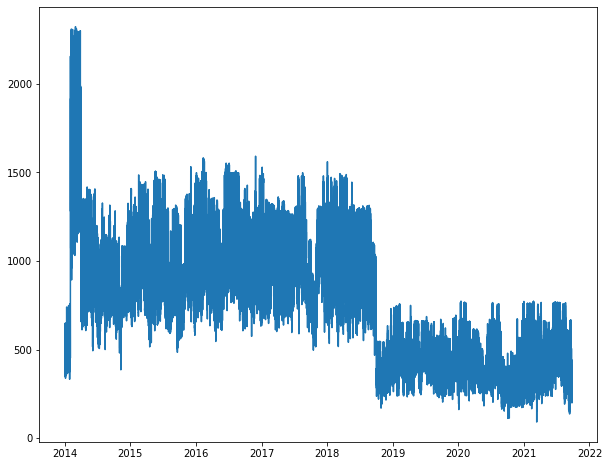

In [12]:
plt.figure(figsize=(10,8))
plt.plot(df)

<h2>Note:</h2>
<p>From late 2018 onwards, the graph shows a clear shift in the trend of energy production. Upon further research, it was discovered that Australia passed a new energy policy leading to this change.</p>
<p>Therefore, for forecasting purposes, it makes more sense to use the data after the point at which this change occurs, i.e, approximately October 2018 onwards.<p>

In [13]:
#taking the subset of data from Oct. 2018 onwards
df = df[df.index >= '2018-10']
df.shape

(52384, 1)

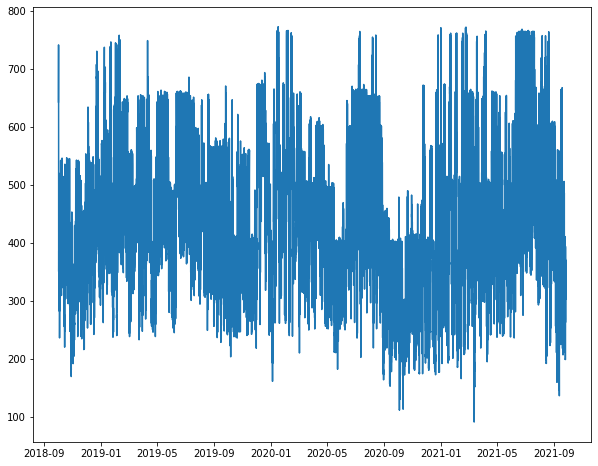

In [14]:
plt.figure(figsize=(10,8))
plt.plot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3f1d0c5650>]],
      dtype=object)

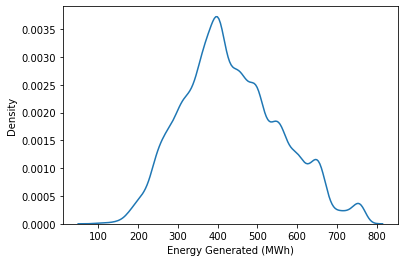

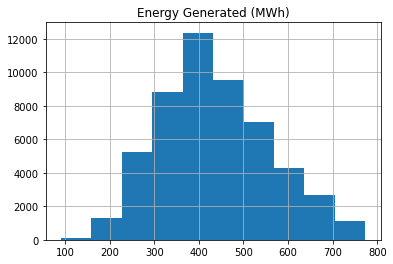

In [15]:
sns.kdeplot(df['Energy Generated (MWh)'])
df.hist()

In [16]:
#Checking for stationarity
result = adfuller(df.values.flatten())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -13.938899
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


**The data is stationary as p-value < significance level.**

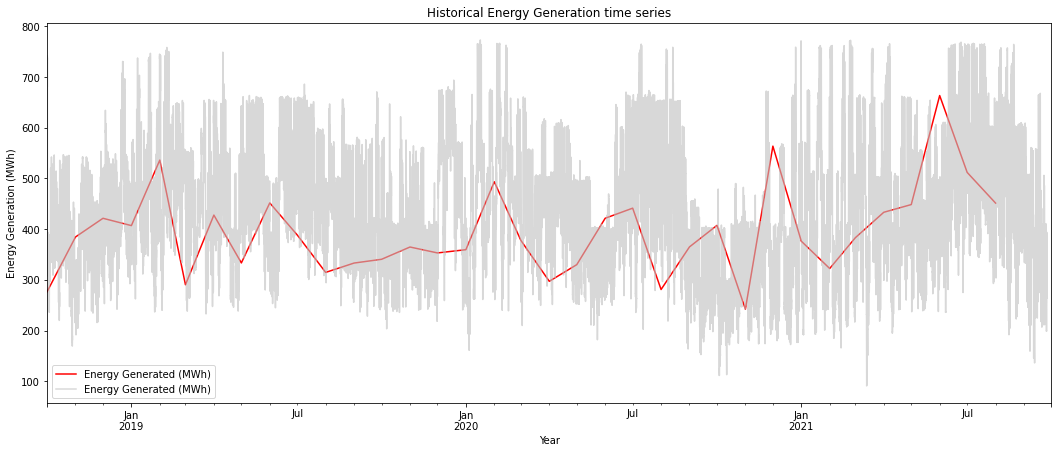

In [17]:
index_monthly = pd.date_range('2018-10', '2021-11', freq='1M')
df_smooth = df.reindex(index=index_monthly).interpolate('cubic')
df_smooth = df_smooth.rename(columns={'value':'smooth'})

fig, axs = plt.subplots(1,1, figsize=(18,7))

df_smooth.plot(ax=axs, alpha=2, color='red')
df.plot(ax=axs, alpha=0.6, color='0.75')
plt.title('Historical Energy Generation time series')
plt.xlabel('Year')
plt.ylabel('Energy Generation (MWh)')
plt.legend()
fig.show()

In [18]:
df.describe()

,Energy Generated (MWh)
count,52384.000000
mean,435.641634
std,122.993766
min,90.862000
25%,349.214250
50%,420.842500
75%,515.697750
max,773.165000


**<h2>Checking for yearly, weekly and daily seasonality</h2>**

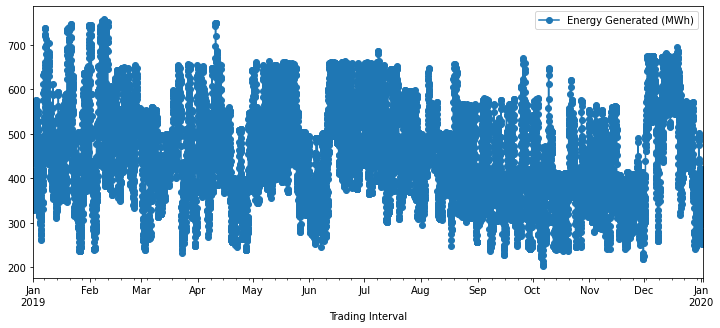

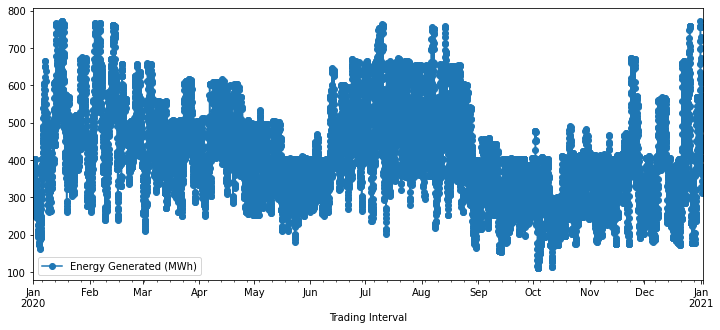

In [15]:
def plot(data, start, end):
    data.loc[start:end].plot(figsize=(12,5), style='o-')
    plt.show()  


plot(df, '2019-01-01', '2020-01-01')
plot(df, '2020-01-01', '2021-01-01')

**No obvious yearly seasonality or seasonality across different seasons or months.**

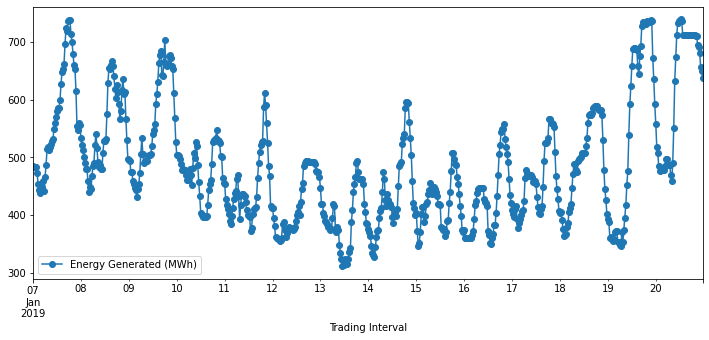

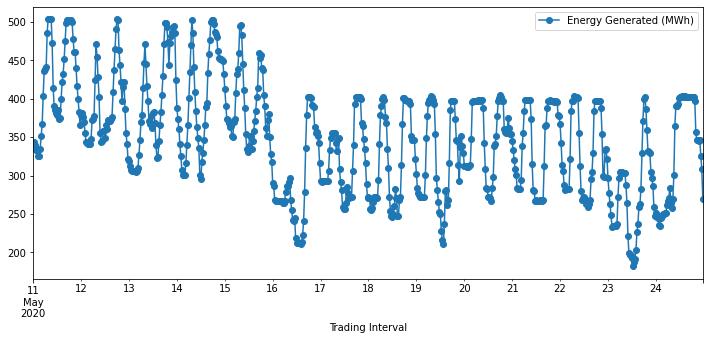

In [16]:
plot(df, '2019-01-07', '2019-01-20')
plot(df, '2020-05-11', '2020-05-24')

**Minima reached during weekends, while weekdays show fairly similar levels of production.**

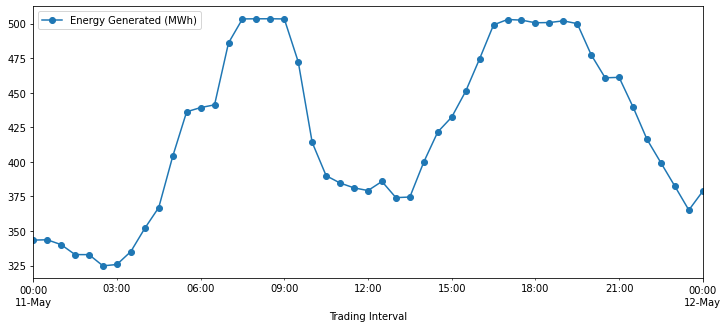

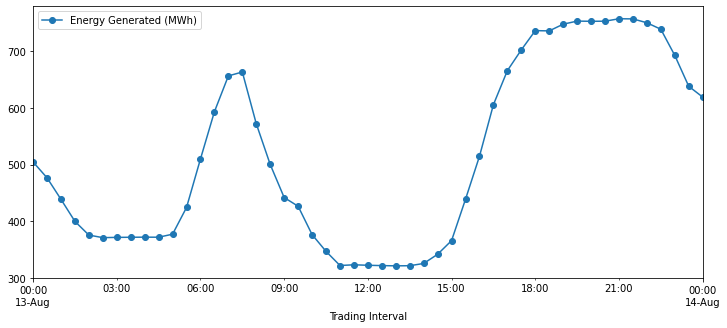

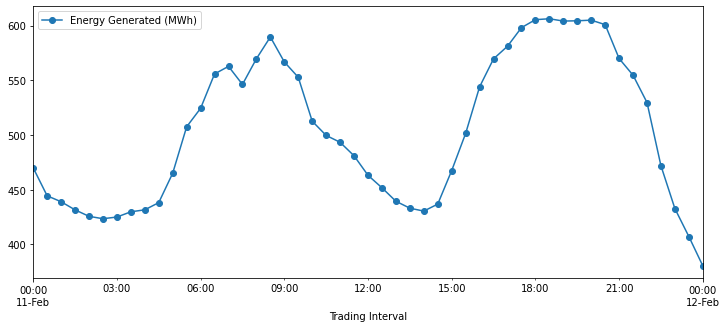

In [17]:
plot(df, '2020-05-11 00:00:00', '2020-05-12 00:00:00')
plot(df, '2021-08-13 00:00:00', '2021-08-14 00:00:00')
plot(df, '2019-02-11 00:00:00', '2019-02-12 00:00:00')

**Alternating increasing and decreasing trends from:**
 - ~ ( 3 am - 9 am )
 - ~ ( 9 am - 3 pm )
 - ~ ( 3 pm - 9 pm )
 - ~ ( 9 pm - 3 am )

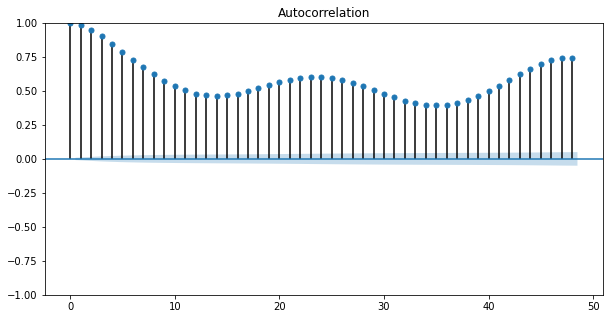

In [18]:
with rc_context():
    rc("figure", figsize=(10,5))
    plot_acf(df['Energy Generated (MWh)'])
    plt.show()

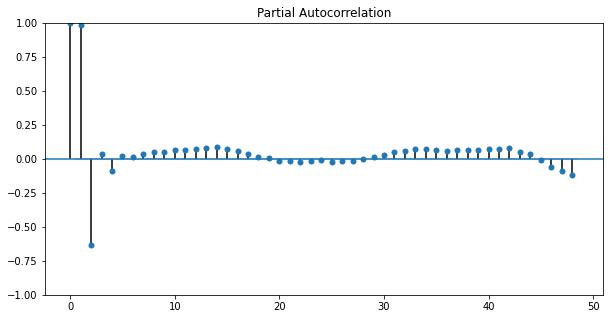

In [19]:
with rc_context():
    rc("figure", figsize=(10,5))
    plot_pacf(df['Energy Generated (MWh)'], method='ywm')
    plt.show()

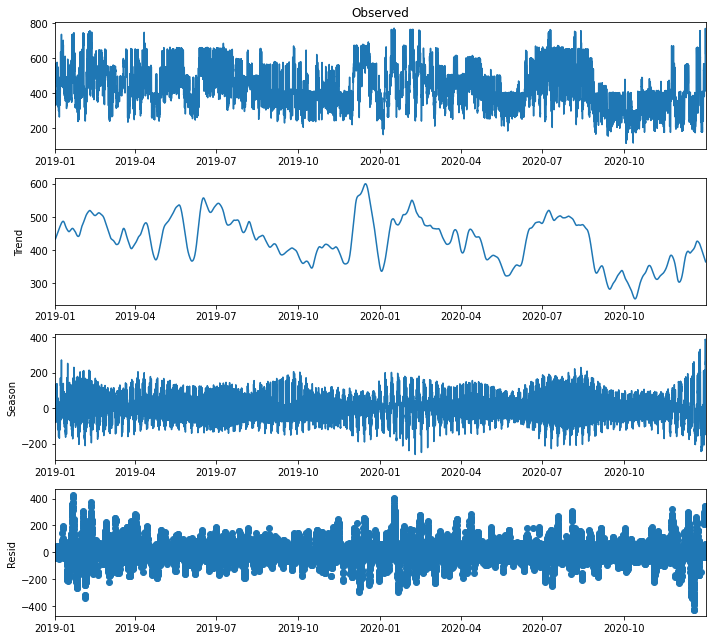

In [20]:
plt.rcParams.update({'figure.figsize':(10,9)})
stl = STL(df['2019':'2020'], period=48*7, robust=True) #48*7 half-hour intervals in a week
res = stl.fit()
fig = res.plot()

In [19]:
df.index.names = ['ds']
df.rename(columns={'Energy Generated (MWh)' : 'y'}, inplace=True)

In [20]:
def split_df(df, val=True):
  '''Splits data into training, validations and test sets'''

  train_end_date = '2021-06-01 00:00:00'
  train_vals = df.loc[:train_end_date, :]
  test_df = df.loc[train_end_date:, :]

  train_vals.reset_index(inplace=True)
  test_df.reset_index(inplace=True)
  
  if not val:
    return train_vals, test_df
  
  train_len = len(train_vals)
  cutoff_pt = int(train_len*0.8)

  train_df = train_vals[:cutoff_pt]
  val_df = train_vals[cutoff_pt:]

  return train_df, val_df, test_df

In [21]:
train_df, val_df, test_df = split_df(df)

<h1>Prophet model</h1>

*y<sub>t</sub> = g(t) &nbsp; x &nbsp; s(t) &nbsp; x &nbsp; h(t)
<br><br>
y<sub>t</sub> -> time series <br>
g(t) -> trend function <br>
s(t) -> seasonality <br>
h(t) -> irregularity or effect of holidays*

In [22]:
#default Prophet model
model1 = Prophet(interval_width=0.95)
model1.fit(train_df)

In [23]:
future = model1.make_future_dataframe(periods=len(val_df), freq='0.5H')
forecast = model1.predict(future)

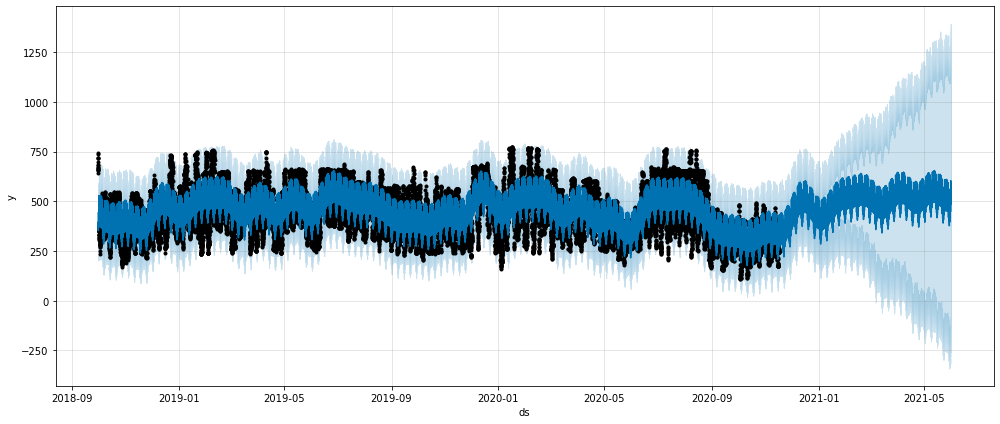

In [17]:
fig1 = model1.plot(forecast, figsize=(14,6))

In [24]:
def plot(forecast, train, x1,x2):
    '''Plots forecast and train data with confidence limits, and x1 starting timestamp and x2 ending timestamp.
    Also plots time series 1 vs time series 2.'''
    #plot1
    yhat = forecast.set_index('ds').loc[x1:x2, 'yhat']
    y = train.set_index('ds').loc[x1:x2, 'y']
    plt.figure(figsize=(14,6))
    plt.plot(y, 'o', label='True')
    plt.plot(yhat, 'o-', label='Estimated')
    lower_bound = forecast.set_index('ds').loc[x1:x2, 'yhat_lower']
    upper_bound = forecast.set_index('ds').loc[x1:x2, 'yhat_upper']
    plt.fill_between(yhat.index, lower_bound, upper_bound, alpha=0.25)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Energy Generation (MWh)')
    plt.show()

    #plot2
    plt.figure(figsize=(10,4))
    plt.scatter(x=y, y=yhat)
    Xmin = int(np.floor(np.min([yhat.min(), y.min()]))) 
    Xmax = int(np.ceil(np.max([yhat.max(), y.max()])))
    r = range(Xmin, Xmax)
    plt.plot(r, r, 'r', label='y=x')
    plt.title('True values(x) vs estimated values(y)')
    plt.legend()
    plt.xlabel('Energy Generation (MWh)')
    plt.ylabel('Energy Generation (MWh)')
    plt.show()

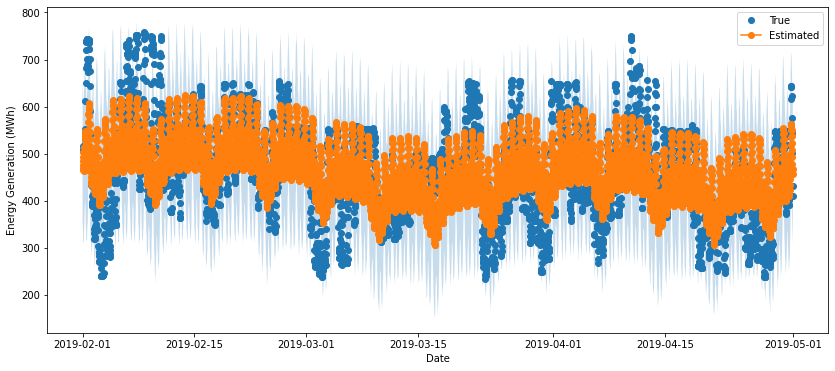

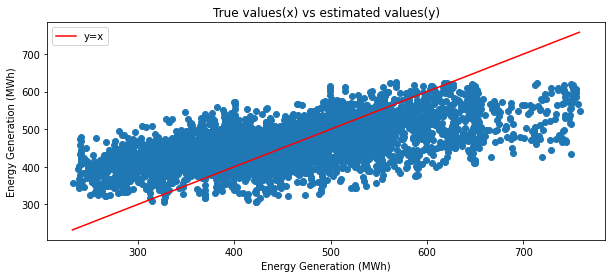

In [28]:
plot(forecast, train_df, '2019-02', '2019-04')

In [25]:
def acf_res(forecast, train):
    '''Plots autocorrelation of the residuals (true values - predicted values) for the training data.'''
    date_range = train['ds']
    res = train.set_index('ds')['y'] - forecast.set_index('ds').loc[date_range, 'yhat']
    plot_acf(res)

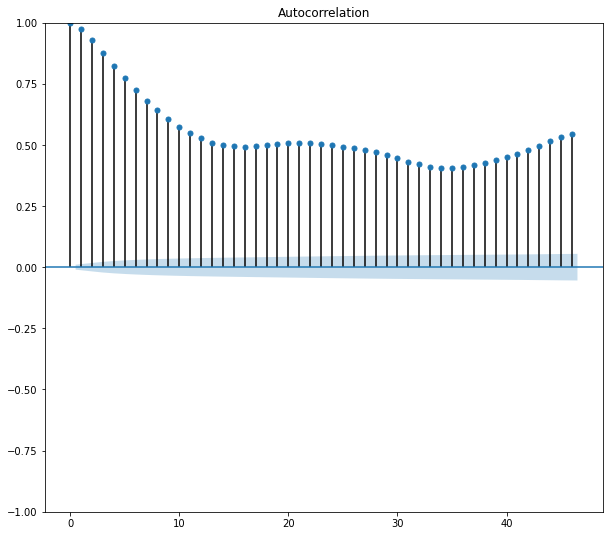

In [30]:
acf_res(forecast, train_df)

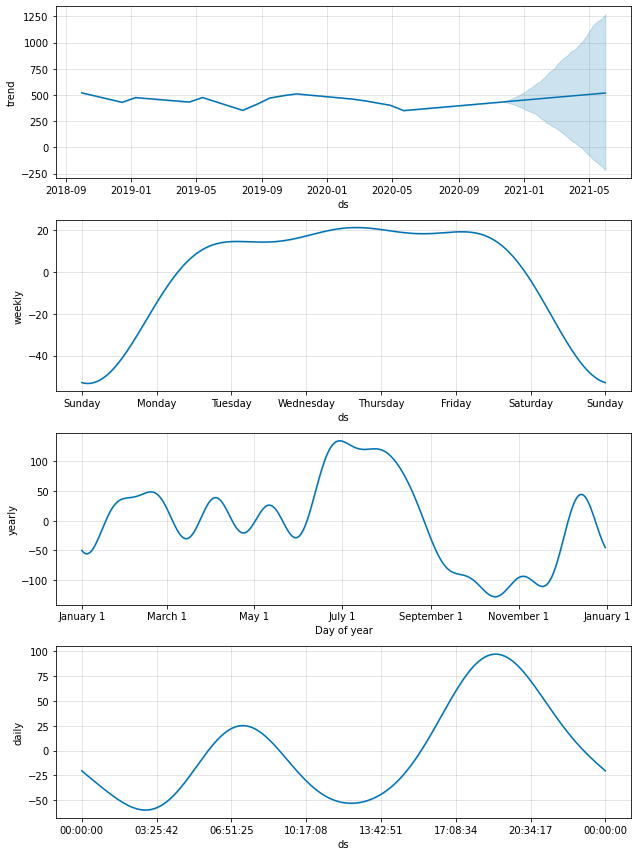

In [31]:
fig2 = model1.plot_components(forecast)

In [26]:
#Functions to add some custom parameters to the dataframe

def to_log(df, colnames):
  '''Converts values in given df columns to logarithmic form'''

  res = df.copy()
  for colname in colnames:
    res[colname] = res[colname].apply(np.log)
  
  return res
    
def is_weekend(ds):
  '''Returns true if given date is a weekend'''

  return ds.day_name() in ['Saturday', 'Sunday']

def is_weekday(ds):
  '''Returns true if given date is not a weekend'''

  return not is_weekend(ds)

def add_custom_seasonality(df):
  '''Adds custom seasonal component to the dataframe'''

  df = df.assign(
      weekend = df['ds'].apply(is_weekend),
      weekday = df['ds'].apply(is_weekday),
      )
  
  return df

In [27]:
train_df, val_df, test_df = split_df(to_log(df, ['y']))
train_df = add_custom_seasonality(train_df)
val_df = add_custom_seasonality(val_df)
test_df = add_custom_seasonality(test_df)
future = add_custom_seasonality(future)

In [29]:
def tuned_model():
  model = Prophet(
      interval_width=0.95,
      changepoint_prior_scale=0.5,
      seasonality_prior_scale=0.5,
      daily_seasonality=True,
      weekly_seasonality=True,
      yearly_seasonality=True)
  
  model.add_seasonality(name='weekday', period=5, fourier_order=12, condition_name='weekday')
  model.add_seasonality(name='weekend', period=2, fourier_order=12, condition_name='weekend')
  
  return model

In [30]:
model2 = tuned_model()
model2.fit(train_df)

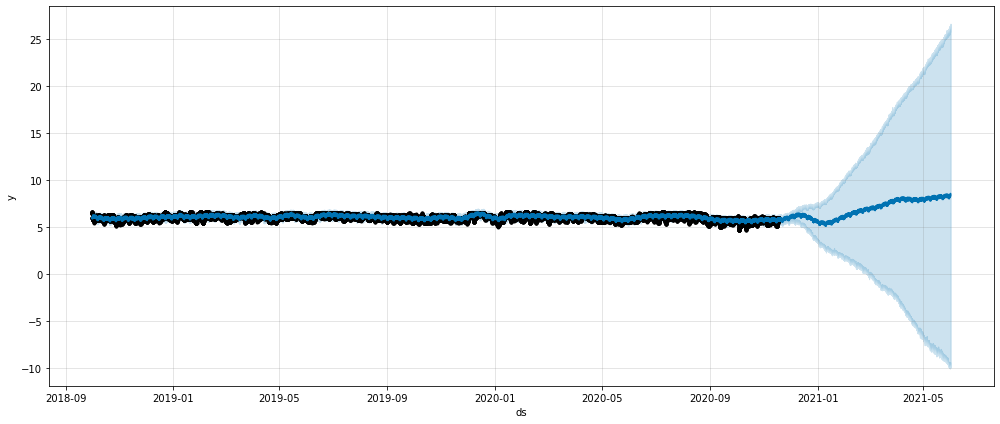

In [31]:
new_forecast = model2.predict(future)

fig1 = model2.plot(new_forecast, figsize=(14,6))

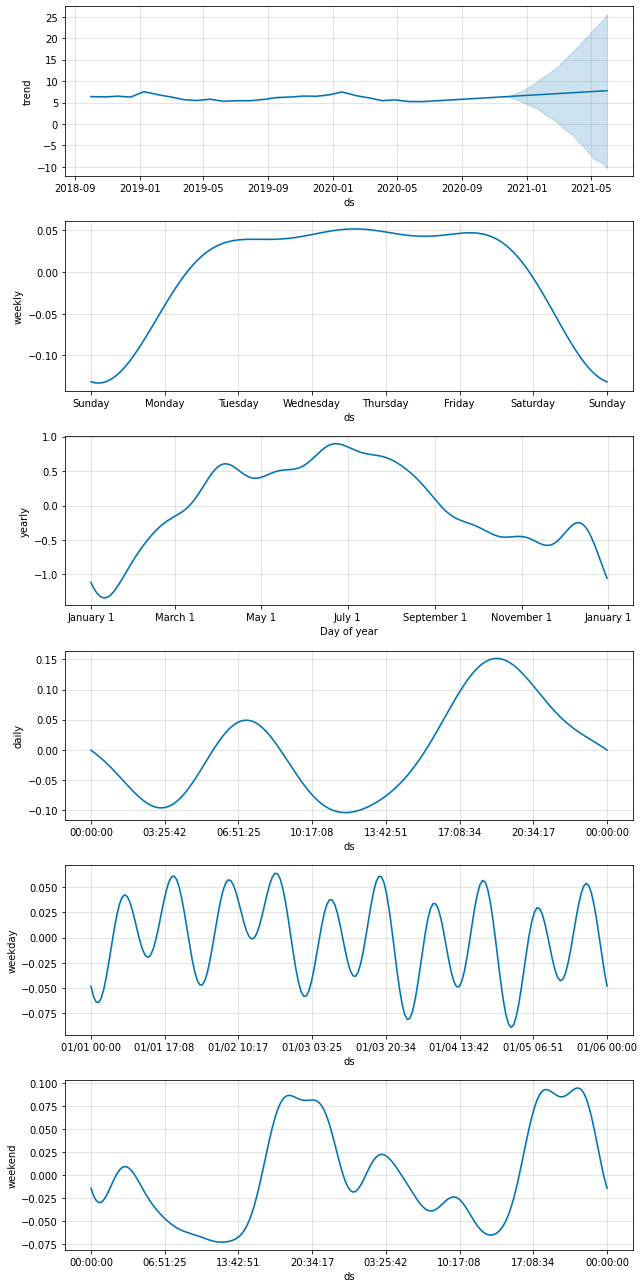

In [51]:
fig2 = model2.plot_components(new_forecast)

In [32]:
def to_exp(df, colnames):
  '''Converts values in given df columns to its calculated exponential'''
  res = df.copy()
  for colname in colnames:
    res[colname] = res[colname].apply(np.exp)
    
  return res

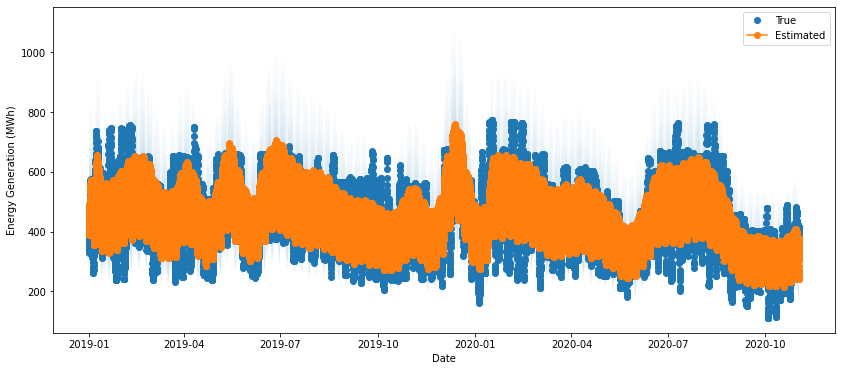

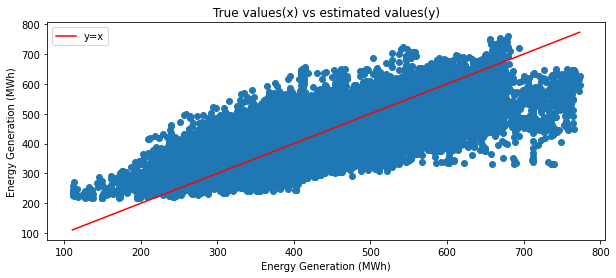

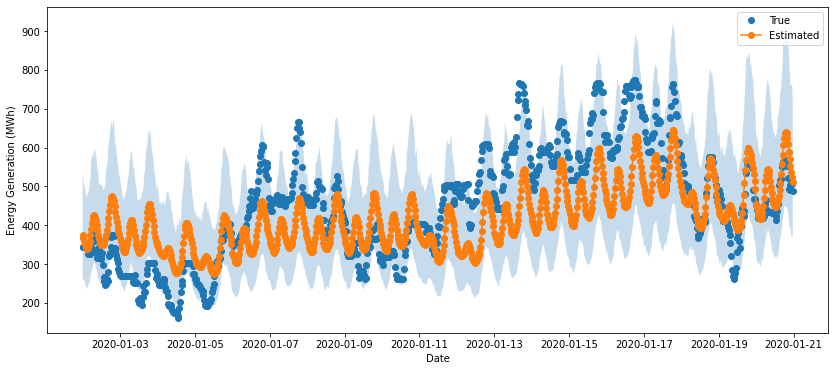

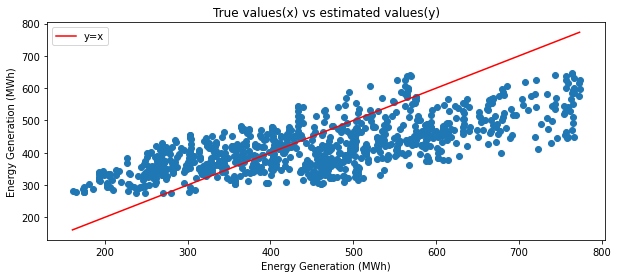

In [33]:
plot(to_exp(new_forecast, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(train_df, ['y']), '2019-01-01', '2020-11-01')
plot(to_exp(new_forecast, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(train_df, ['y']), '2020-01-02', '2020-01-20')

In [34]:
def mape(ytrue, ypred):
  '''Calculates mean absolute percentage error'''
  
  return np.mean(np.abs(1-ypred/ytrue))

In [46]:
#Cross validation to compare different forecasts' error scores using the tuned Prophet model
cv_df = cross_validation(model2, initial='365.25 days', period='30 days', horizon='30 days', parallel="processes")

INFO:fbprophet:Making 13 forecasts with cutoffs between 2019-10-25 04:30:00 and 2020-10-19 04:30:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f3f1d0cf610>


In [47]:
perf_df = performance_metrics(cv_df)
perf_df

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days 00:00:00,0.037086,0.192577,0.155578,0.026015,0.023237,0.916667
1,3 days 00:30:00,0.037121,0.192668,0.155685,0.026033,0.023331,0.916667
2,3 days 01:00:00,0.037168,0.192791,0.155794,0.026050,0.023383,0.916667
3,3 days 01:30:00,0.037221,0.192927,0.155876,0.026065,0.023383,0.916667
4,3 days 02:00:00,0.037273,0.193062,0.155923,0.026075,0.023383,0.916667
...,...,...,...,...,...,...,...
1292,29 days 22:00:00,0.988018,0.993991,0.797742,0.132967,0.096962,0.993056
1293,29 days 22:30:00,0.988326,0.994146,0.798037,0.133013,0.096983,0.993056
1294,29 days 23:00:00,0.988577,0.994272,0.798281,0.133049,0.097019,0.993056
1295,29 days 23:30:00,0.988716,0.994342,0.798424,0.133070,0.097019,0.993056


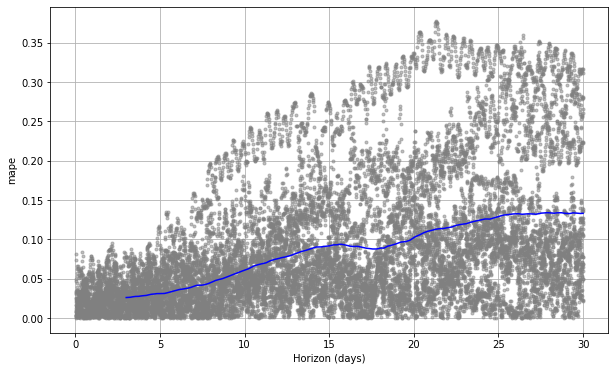

In [48]:
cv_fig = plot_cross_validation_metric(cv_df, metric='mape')

In [36]:
#Training the model on the complete training set (no validation set)
train, test = split_df(to_log(add_custom_seasonality(df.reset_index()), ['y']).set_index('ds'), val=False)
final_tuned_model = tuned_model()
final_tuned_model.fit(train)

In [37]:
future = final_tuned_model.make_future_dataframe(periods=len(test), freq='0.5H')
future = add_custom_seasonality(future)
forecast = final_tuned_model.predict(future)

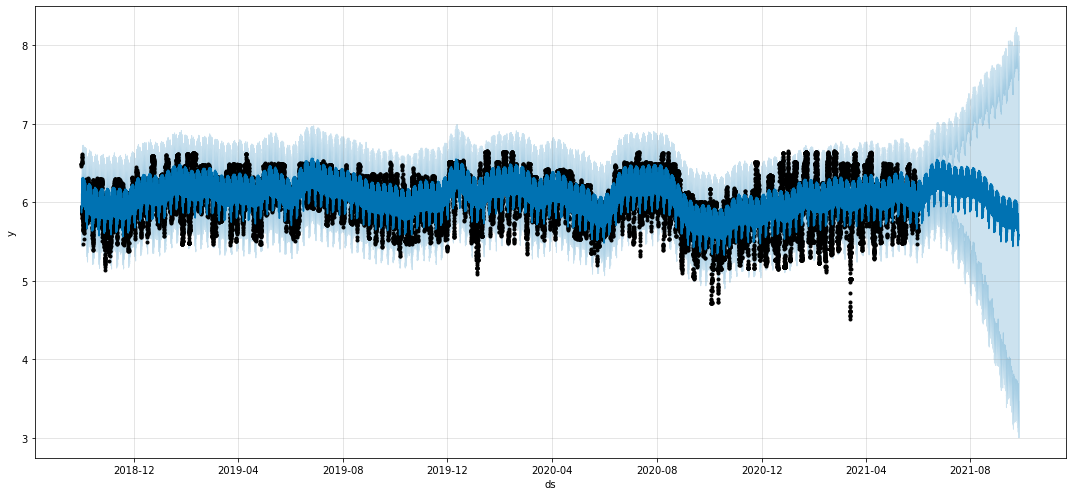

In [38]:
fig1 = final_tuned_model.plot(forecast, figsize=(15,7))

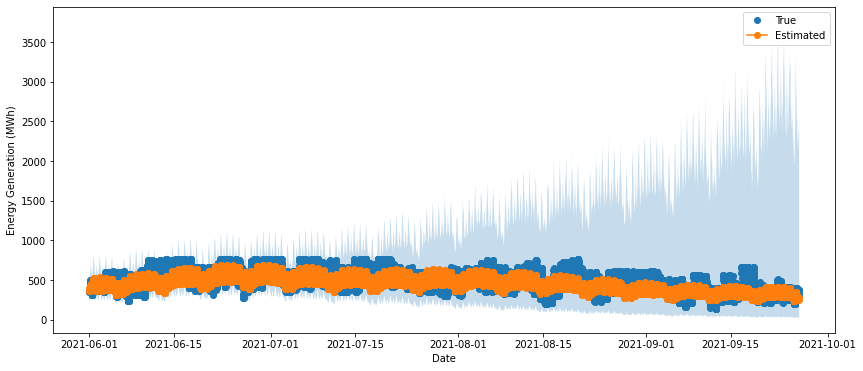

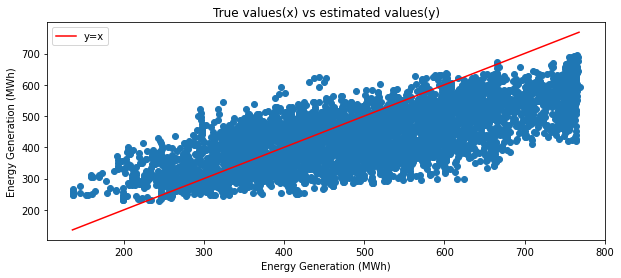

In [39]:
plot(to_exp(forecast, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(test, ['y']), '2021-06-01 00:00:00', '2021-09-26 07:30:00')

In [40]:
y_true = to_exp(test, ['y'])['y']
y_predicted = to_exp(forecast, ['yhat']).set_index('ds').loc['2021-06-01 00:00:00':'2021-09-26 07:30:00'].reset_index()['yhat']
rmse = np.sqrt(mean_squared_error(y_true, y_predicted))

print('FINAL TUNED MODEL:')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Mean absolute percentage error: {mape(y_true, y_predicted):.2f}')

FINAL TUNED MODEL:
Root mean squared error: 116.69
Mean absolute percentage error: 0.19


In [49]:
#Training the default model on the complete training set (no validation set)
train, test = split_df(df, val=False)
default_model = Prophet()
default_model.fit(train)
future = default_model.make_future_dataframe(periods=len(test), freq='0.5H')
forecast = default_model.predict(future)

In [50]:
y_default_predicted = forecast.set_index('ds').loc['2021-06-01 00:00:00':'2021-09-26 07:30:00'].reset_index()['yhat']
rmse2 = np.sqrt(mean_squared_error(test['y'], y_default_predicted))
print('DEFAULT MODEL:')
print(f'Root mean squared error: {rmse2:.2f}')
print(f'Mean absolute percentage error: {mape(test["y"], y_default_predicted):.2f}')

DEFAULT MODEL:
Root mean squared error: 110.32
Mean absolute percentage error: 0.19


The tuned model performs slightly worse than the default model with same MAPE score but greater RMSE. Further hyperparameter tuning is required to improve the model significantly.